### Problem Description : 
    A retail company “ABC Private Limited” wants to understand the customer purchase behaviour(specifically, purchase amount) 
against various products of different categories. They have shared purchase summary of various customers for selected 
high volume products from last month.

    The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), 
product details (product_id and product category) and Total purchase_amount from last month.

    Now, they want to build a model to predict the purchase amount of customer against various products which will help 
them to create personalized offer for customers against different products.

#### Regression or Classification problem ?
    Our goal is to predict Purchase amount of customer against each product which has continuous value. So to predict continuous value, We use Regression model.

In [79]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [80]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample.csv")


In [81]:
print(train.shape)
print(test.shape)


(550068, 12)
(233599, 11)


In [82]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


#### Observations
- Occupation , Product_Category_1 , Product_Category_2, Product_Category_3 values are masked
- No information about stores
- Few information related to products which are product id and the product that falls under different product category
- We have some information related to the Customer such as Age,Gender,Occupation and Maritial_status


#### Assumptions
- We make some assumptions before start,We'll analyse the given features that influence amount spend by customer
- <b>Occupation</b> - People with higher income spend more 
- <b>Marital_Status</b> - People who are single spend more because saving the money is not their first preference
- <b>City_Category</b> - People from urban city or top tier city spend more because of their higher income level
- <b>Age</b> - People who are below 30 years spend more on gadgets and other electronics stuff

Skewness : 0.6001400037087128
Kurtosis : -0.3383775655851702


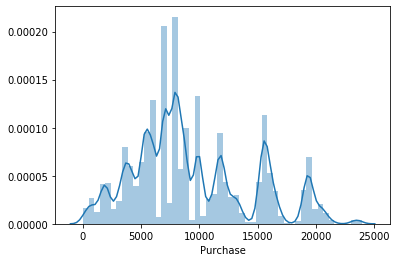

In [73]:
sns.distplot(train['Purchase'])
print("Skewness : {}".format(train['Purchase'].skew()))
print("Kurtosis : {}".format(train.Purchase.kurt()))

In [84]:
# The distribution is moderately skewed

### Data Cleaning

In [85]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [86]:
test.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

In [76]:
# Let's analyse the missing value
# Product_Category_2 & Product_Category_3 has missing values this might be due to that products did not fall under these two categories
train[train['Product_Category_2'].isnull()]['Product_ID'].value_counts()

P00255842    1383
P00278642    1226
P00031042    1200
P00258742     964
P00110542     958
             ... 
P00306542       1
P00074542       1
P00260742       1
P00353742       1
P00203942       1
Name: Product_ID, Length: 1828, dtype: int64

In [77]:
# We analyse firt two top products
print(train[train['Product_ID']=='P00255842']['Product_Category_2'].value_counts(dropna=False))
print(train[train['Product_ID']=='P00278642']['Product_Category_2'].value_counts(dropna=False))

NaN    1383
Name: Product_Category_2, dtype: int64
NaN    1226
Name: Product_Category_2, dtype: int64


In [78]:
train[train['Product_Category_3'].isnull()]['Product_ID'].value_counts()

P00265242    1880
P00058042    1422
P00255842    1383
P00117942    1364
P00110942    1360
             ... 
P00104342       1
P00352042       1
P00166442       1
P00126742       1
P00065542       1
Name: Product_ID, Length: 3103, dtype: int64

In [10]:
# We analyse firt two top products
print(train[train['Product_ID']=='P00265242']['Product_Category_3'].value_counts(dropna=False))
print(train[train['Product_ID']=='P00058042']['Product_Category_3'].value_counts(dropna=False))

NaN    1880
Name: Product_Category_3, dtype: int64
NaN    1422
Name: Product_Category_3, dtype: int64


In [87]:
# Our guess on product that doesn't fall under these categories are correct, so it is safe to fill 0
train['Product_Category_2'].fillna(0,inplace=True)
test['Product_Category_2'].fillna(0,inplace=True)
train['Product_Category_3'].fillna(0,inplace=True)
test['Product_Category_3'].fillna(0,inplace=True)

In [88]:
# we remove + character
train['Stay_In_Current_City_Years'] = train['Stay_In_Current_City_Years'].replace("4+","4")
test['Stay_In_Current_City_Years'] = test['Stay_In_Current_City_Years'].replace("4+","4")

train['Age'] = train['Age'].replace('55+','56-100')
test['Age'] = test['Age'].replace('55+','56-100')

#### Feature Transformation

In [89]:
#Product ID has so many unique values that won't help us but there is a pattern on product formation. We will split first 4 
#characters this might be some sellers name or for some identification they kept it

In [90]:
train['Product_Name'] = train['Product_ID'].str.slice(0,4)
test['Product_Name'] = test['Product_ID'].str.slice(0,4)

#### Feature Creation

In [92]:
train['User_ID'].value_counts()

1001680    1026
1004277     979
1001941     898
1001181     862
1000889     823
           ... 
1000094       7
1002111       7
1004991       7
1005608       7
1000708       6
Name: User_ID, Length: 5891, dtype: int64

In [93]:
# Each user has purchased atleast 6 items.
# Based on the count  we'll create a new variable called Frequent_Buyers which holds 1 for Users who purchased more than 100 items
# and 0 for less than 100 items

In [94]:
train['Frequent_Buyers'] = train.groupby('User_ID')['User_ID'].transform(lambda x : 1 if x.count() > 100 else 0)
test['Frequent_Buyers'] = test.groupby('User_ID')['User_ID'].transform(lambda x : 1 if x.count() > 100 else 0)

In [95]:
train.drop(['Product_ID','User_ID'],inplace=True,axis=1)
test.drop(['Product_ID','User_ID'],inplace=True,axis=1)

In [96]:
train['Age'].value_counts()

26-35     219587
36-45     110013
18-25      99660
46-50      45701
51-55      38501
56-100     21504
0-17       15102
Name: Age, dtype: int64

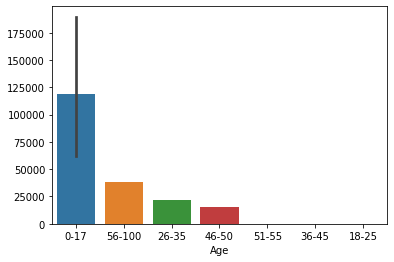

In [22]:
sns.barplot(train['Age'],train['Age'].value_counts().values)

In [97]:
#teenagers or student shows more interest than other ages
train[train['Age'] == '0-17']['Occupation'].value_counts()[10] / train[train['Age'] == '0-17']['Occupation'].shape[0] * 100

72.51357436101179

In [24]:
# 72% of "0-17" doing the same occupation(probably they are student)

In [98]:
# We'll create a new feature for Student
train['IsStudent'] = 1 * (train['Age']=='0-17')
test['IsStudent'] = 1 * (test['Age']=='0-17')

In [99]:
# Based on our income we spend more, so we'll order occupation by mean value of the purchase and we use the same order for test data also.
order_occupation_by_purchase = train.groupby('Occupation')['Purchase'].describe().sort_values('mean',ascending=False)['mean'].index

In [27]:
map_occupation = {k: v for v, k in enumerate(order_occupation_by_purchase)}
map_occupation

{17: 0,
 12: 1,
 15: 2,
 8: 3,
 14: 4,
 7: 5,
 16: 6,
 5: 7,
 13: 8,
 6: 9,
 4: 10,
 11: 11,
 3: 12,
 18: 13,
 0: 14,
 10: 15,
 1: 16,
 2: 17,
 20: 18,
 19: 19,
 9: 20}

In [100]:
train['Occupation'] = train['Occupation'].apply(lambda x: map_occupation[x])
test['Occupation'] = test['Occupation'].apply(lambda x: map_occupation[x])

#### Extraordinary Data Analysis

In [101]:
corrIndex = train.corr().nlargest(10,'Purchase')['Purchase'].index
corr = train[corrIndex].corr()

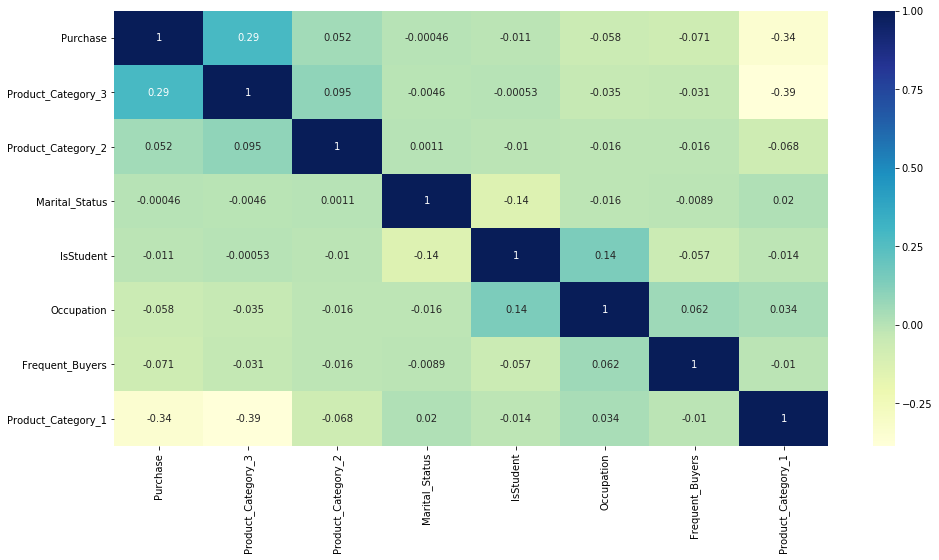

In [102]:
plt.figure(figsize=(16,8))
ax = sns.heatmap(corr,annot=True,cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [103]:
# There is no satisifactory correlation feature so we will avoid using Linear model.

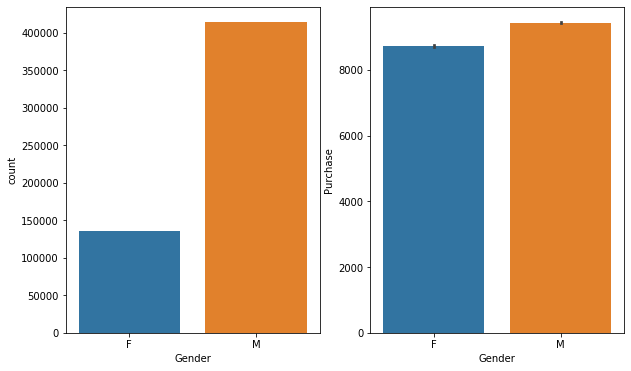

In [32]:
f,ax = plt.subplots(1,2,figsize=(10,6))
sns.countplot(train['Gender'],ax=ax[0])
sns.barplot('Gender','Purchase',data=train,ax=ax[1])

Men was the most shown interest on black friday sales. On plot 2, Eventhough women are less in count but they spent almost equal money spent by men

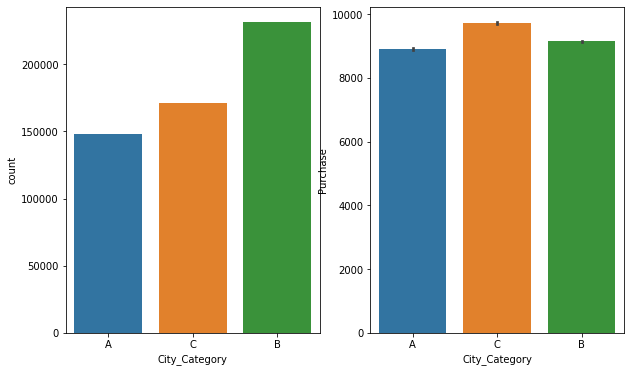

In [33]:
# f,ax = plt.subplots(1,2,figsize=(10,6))
# sns.countplot(train['City_Category'],ax=ax[0])
# sns.barplot('City_Category','Purchase',data=train,ax=ax[1])


In [104]:
# Customer from city B has purchased more items.
# Customer from city C has spent higher Amount Eventhough B has purchased more items.

In [ ]:
sns.swarmplot(train['Marital_Status'],train['Purchase'])

#### Model Training

In [36]:
train = pd.get_dummies(train[:10000],drop_first=True)
test = pd.get_dummies(test,drop_first=True)

In [37]:
y = train['Purchase'][:10000]

In [38]:
train.drop('Purchase',inplace=True,axis=1)

In [39]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [40]:
def feature_importance(values,columns):
    df = pd.Series(values, columns).sort_values(ascending=False)
    df.plot(kind='bar')

In [ ]:
# Support Vector Regressor
rf = RandomForestRegressor(n_estimators = 500)


# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006,random_state=42)

knn = KNeighborsRegressor(n_neighbors=5)

In [43]:
def cv_rmse(model, X=train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [45]:
model_score = {}

In [44]:
score = cv_rmse(rf)
rf_data = rf.fit(train, y)
print("RF: {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['rf'] = score.mean()

feature_importance()

SVR: 4999.8462 (109.6031)


NameError: name 'model_score' is not defined

In [48]:
score = cv_rmse(xgboost)
xgboost_model = xgboost.fit(train,y)
print("XGB: {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['xgb'] = score.mean()

feature_importance()

C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:20:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:21:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:21:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:21:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:23:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:23:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:23:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\john\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[07:24:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: 2913.4976 (98.6830)


In [49]:
score = cv_rmse(knn)
knn_model = knn.fit(train, y)
print("KNN : {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['knn'] = score.mean()
feature_importance()

{'svr': 4999.846224573143, 'xgb': 2913.497604400875}